<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px;">

## Hypothesis Testing, Power Analysis, and Bootstrapping

Week 6 | 2.1

---

This is an extensive Lecture/lab mixture that covers:

1. Hypothesis testing including performing the z-test and t-test.
2. Calculation of confidence intervals.
3. Power analysis and sample size calculation.
4. Bootstrapping for measuring uncertainty of statistics on samples.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
hr = pd.read_csv("/Users/kiefer/github-repos/DSI-SF-4/datasets/hr_analytics/HR_comma_sep.csv")
star = pd.read_csv('/Users/kiefer/github-repos/DSI-SF-4/datasets/starcraft/SkillCraft1_Dataset.csv')

---

### Clean datatypes and clean the Starcraft data

In [3]:
star.dtypes

GameID                    int64
LeagueIndex               int64
Age                      object
HoursPerWeek             object
TotalHours               object
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

In [4]:
star.Age.unique()

array(['27', '23', '30', '19', '32', '21', '17', '20', '18', '16', '26',
       '38', '28', '25', '22', '29', '24', '35', '31', '33', '37', '40',
       '34', '43', '41', '36', '44', '39', '?'], dtype=object)

In [5]:
def try_make_float(x):
    try:
        return float(x)
    except:
        return np.nan

In [6]:
for col in ['Age','HoursPerWeek','TotalHours']:
    star[col] = star[col].map(try_make_float)

In [7]:
star.isnull().sum()

GameID                   0
LeagueIndex              0
Age                     55
HoursPerWeek            56
TotalHours              57
APM                      0
SelectByHotkeys          0
AssignToHotkeys          0
UniqueHotkeys            0
MinimapAttacks           0
MinimapRightClicks       0
NumberOfPACs             0
GapBetweenPACs           0
ActionLatency            0
ActionsInPAC             0
TotalMapExplored         0
WorkersMade              0
UniqueUnitsMade          0
ComplexUnitsMade         0
ComplexAbilitiesUsed     0
dtype: int64

In [8]:
star = star.dropna()

In [9]:
star.shape

(3338, 20)

In [10]:
star.head(2)

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27.0,10.0,3000.0,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23.0,10.0,5000.0,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208


---

### Examine the distribution of age

Is this normally distributed? 

There are multiple formal tests for normality. One of the popular ones is the [Shapiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test), which will test if a distribution is not normally distributed (the null hypothesis in this case is that the distribution _is_ normally distributed.)

The test is already built into scipy under `scipy.stats.shapiro`. After plotting the age distribution, use this to formally test if the distribution is normally distributed.

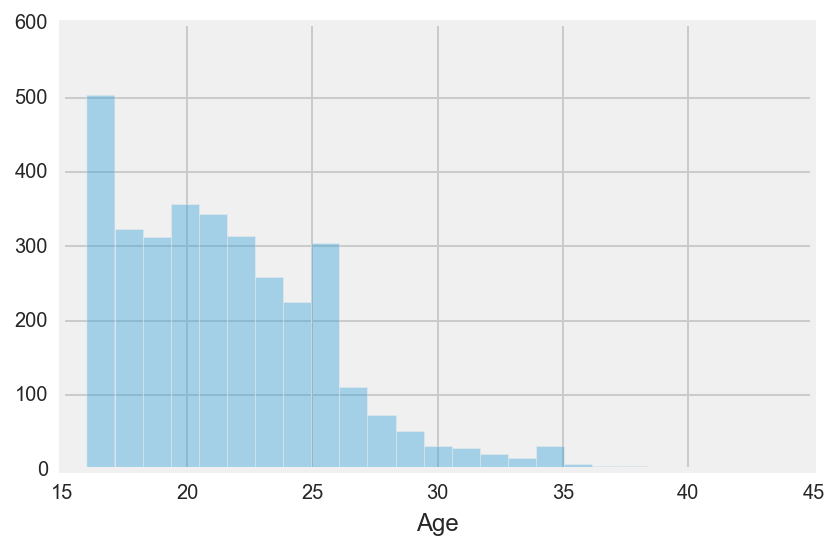

In [11]:
sns.distplot(star.Age, bins=25, kde=False)

In [12]:
stats.shapiro(star.Age.values)

(0.922098696231842, 1.6568877372059564e-38)

---

### The mean age and central limit theorem.

Take 500 random samples of size 20 from the age values in the Starcraft data and calculate the mean age for each. Take another 500 random samples but this time take 100 at a time and calculate the mean for each. 

Plot both of these distributions of means on the same plot. Why do the distributions differ in shape, and how is this difference quantified?

In [13]:
sample = np.random.choice(star.Age, replace=False, size=20)
sample

array([ 20.,  24.,  18.,  24.,  21.,  24.,  22.,  21.,  31.,  39.,  18.,
        20.,  23.,  19.,  26.,  22.,  21.,  17.,  19.,  19.])

In [14]:
np.mean(sample)

22.399999999999999

In [15]:
rs_small = []
rs_large = []
for i in range(500):
    small = np.random.choice(star.Age, replace=False, size=20)
    large = np.random.choice(star.Age, replace=False, size=100)
    rs_small.append(np.mean(small))
    rs_large.append(np.mean(large))

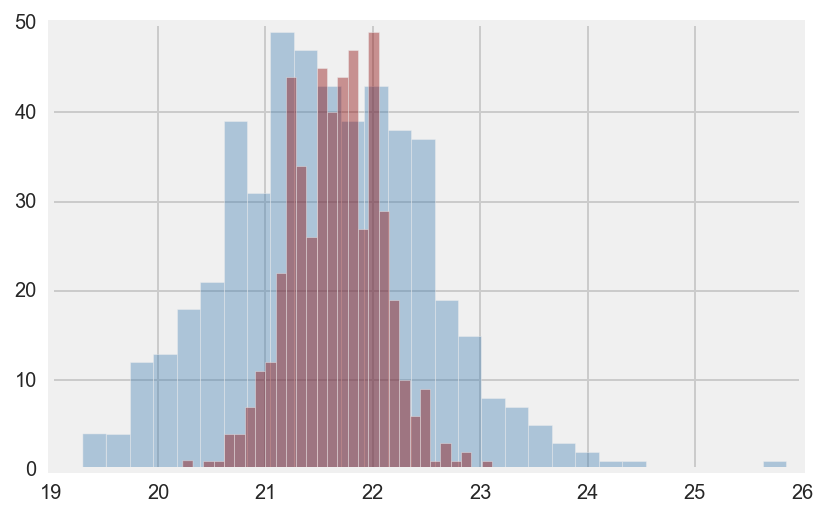

In [16]:
ax = sns.distplot(rs_small, color='steelblue', kde=False, bins=30)
sns.distplot(rs_large, color='darkred', kde=False, bins=30)

In [17]:
#np.mean(star.Age)

The difference between these distributions is quantified by the difference in standard error of the measurement, which defines their standard deviation. 

The standard error of the mean here will be the standard deviation of the `Age` distribution divided by the square root of the number of people in the sample. (Typically you would need to approximate the standard deviation of the age population by replacing it with the standard deviation of the age measurements in your sample.)

#### Do these distributions of means conform to the normal distribution? Test this with the shapiro test as you did before for the age distribution.

In [18]:
stats.shapiro(rs_large)

(0.9969528317451477, 0.4762882590293884)

---

### Calculating a z-statistic

As you may recall, a z-statistic is the standard deviations away from the mean (0) of a unit-variance normal distribution. 

Create a normal distribution object using `scipy.stats.norm` with mean 0 and standard deviation 1. Plot the probability density across a range of x values from -4 to 4 using the `.pdf` function.

In [19]:
np.std(rs_large)

0.4233517705171434

In [20]:
sample = np.random.choice(star.Age, replace=False, size=100)
np.std(sample)/np.sqrt(100)

0.48083261120685233

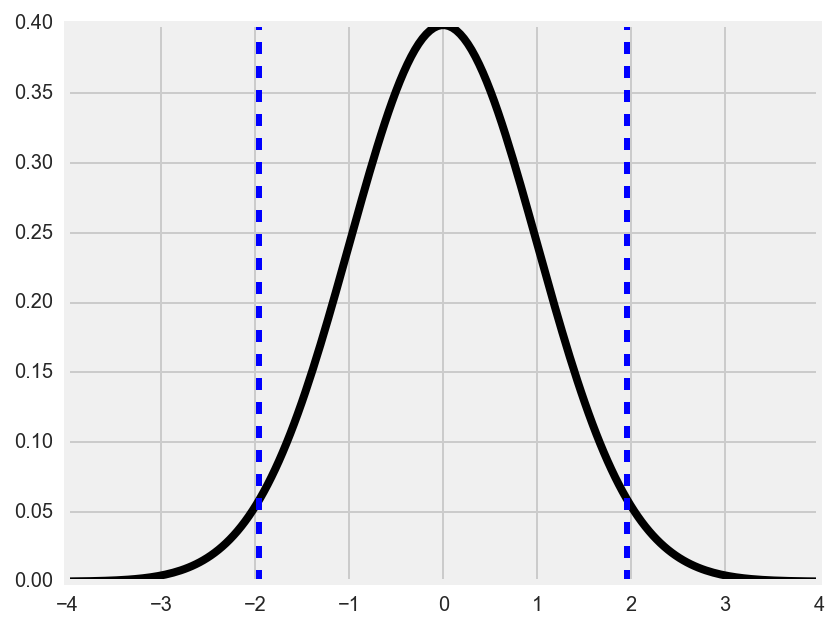

In [21]:
normal = stats.norm(0, 1)

fig, ax = plt.subplots(figsize=(6,5))

x = np.linspace(-4, 4, 200)
y = normal.pdf(x)

ax.plot(x, y, lw=4, color='black')
ax.axvline(normal.ppf(0.975), ls='dashed', lw=3)
ax.axvline(normal.ppf(0.025), ls='dashed', lw=3)
#sns.distplot((rs_large-np.mean(rs_large))/np.std(rs_large), bins=30, kde=True)


plt.show()

Because of the central limit theorem, we know that as n approaches infinity the distribution of sample means becomes normally distributed. 

We can leverage this fact to calculate the _uncertainty_ of our measurement of the mean. This is done with a **confidence interval**. Confidence intervals are unfortunately confusing in their interpretation. A 95% confidence interval does NOT mean "there is a 95% probability that the true mean falls in this range." Remember that in frequentist statistics there is no probability associated with the true parameter/statistic: it is fixed at a specific value.

The correct interpretation of a 95% confidence interval around the mean is instead:

> 95% of repeated experiments that calculate a confidence interval with this threshold (alpha = 0.05) will contain the true mean.

Which means that 95% of hypothetical confidence intervals calculated on samples the same size from the population will contain the true mean.

Note here that the probability is associated with the data, not with the true parameter being estimated. This is the critical difference in frequentist statistics (vs. bayesian); our data has a probability of occuring, but there is no probability of values for the true parameter.

This is confusing and unfortunately there really isn't any way around this. You have to change the way that you intuitively think about probability when doing frequentist statistics. Perhaps an easier way to think about the confidence interval is in terms of the Type I error:

> With a 95% confidence interval, if the true value lies outside of the calculated confidence interval then this is the result of a sampling error which had a 5% probability of occuring.

---

### Calculating the confidence interval of a mean

Leveraging the CLT we can calculate a confidence interval for our sample mean. The CLT states that our sample mean falls on a normal distribution of sample means defined with standard deviation:

### $$ \sigma_{\bar{x}} = \frac{\sigma}{\sqrt{n}} $$

Where $\sigma$ is the overall population standard deviation. In reality we typically do not have the population standard deviation and so would use the sample standard deviation $s$ in its place. This is conventionally considered a valid approach when $n > 30$.

### $$  \sigma_{\bar{x}} = \frac{s}{\sqrt{n}} $$

Where $s$ is the sample standard deviation.

Say we want to calculate a 95% confidence interval around our sample mean. **First, calculate the standard deviations around the unit-variance normal distribution that contains 95% of the area.**

The `.ppf` function that is part of the normal distribution object will be useful for this. It converts percentiles into values (on the x-axis, in this case standard deviations).

In [22]:
normal.ppf(0.5)

0.0

#### Plot the calculated area under the normal curve that makes up the 95% confidence interval.

Now that we have the lower and upper bounds, use the calculated standard error of the mean to convert these z-statistic values into the bounds around our sample mean.

The confidence interval bounds are calculated like so:

### $$ [\; \bar{x} + Z_{\alpha/2}\frac{s}{\sqrt{n}},\; \bar{x} + Z_{1-\alpha/2} \frac{s}{\sqrt{n}} ]$$

#### Calculate the sample mean and 99% confidence interval for age.

In [23]:
alpha = 0.01
Z_upper = normal.ppf(1. - alpha/2.)
Z_lower = normal.ppf(alpha/2.)
print Z_lower, Z_upper

-2.57582930355 2.57582930355


In [24]:
sample = np.random.choice(star.Age, replace=False, size=100)
sample_mean = np.mean(sample)
std_err_mean = np.std(sample)/np.sqrt(100)
#print sample_mean, std_err_mean

conf_lower = sample_mean + std_err_mean*Z_lower
conf_upper = sample_mean + std_err_mean*Z_upper

print conf_lower, sample_mean, conf_upper

20.2550804081 21.19 22.1249195919


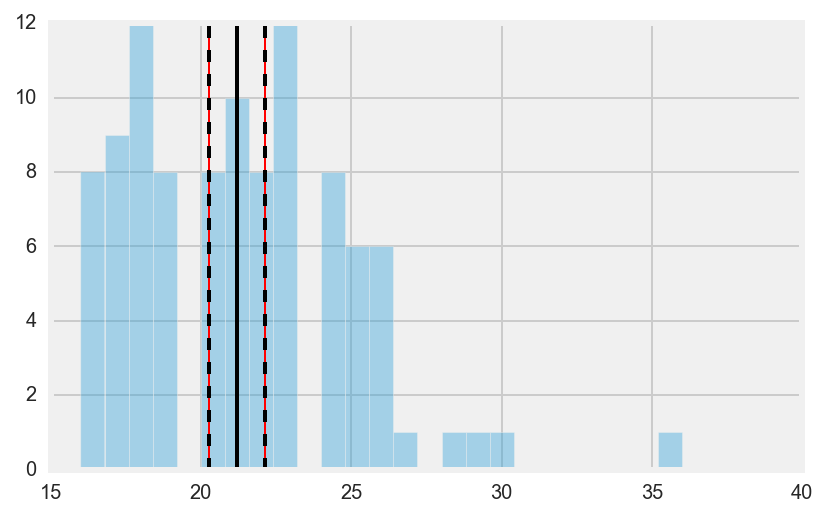

In [25]:
ax = sns.distplot(sample, kde=False, bins=25)
ax.axvline(sample_mean, lw=2, color='black')
ax.axvline(sample_mean+np.std(sample)/np.sqrt(100)*2.58, lw=1, color='red')
ax.axvline(sample_mean-np.std(sample)/np.sqrt(100)*2.58, lw=1, color='red')
ax.axvline(conf_upper, lw=2, color='black', ls='dashed')
ax.axvline(conf_lower, lw=2, color='black', ls='dashed')



#ax.axvline(sample_mean, lw=2, color='black')

---

### The t-statistic vs. z-statistic

[The student t-distribution](https://en.wikipedia.org/wiki/Student's_t-distribution) is essentially a more conservative version of the normal distribution, for when sample sizes are small.

As $n$ grows, the t-distribution approaches the normal distribution. When $n$ is small, the tails of the distribution are "fatter" and thus more density falls further from the mean. This in turn means that confidence intervals calculated on the t-distribution are more conservative.

You can create the t-distribution using `scipy.stats.t`. You will need to specify the degrees of freedom when instantiating this object, which should be $n - 1$. For example, `tdist = stats.t(49)` will create a t-distribution for sample size $n = 50$

**Plot the pdf of the t-distribution for sample size of 5 and sample size of 100 on the same plot.**

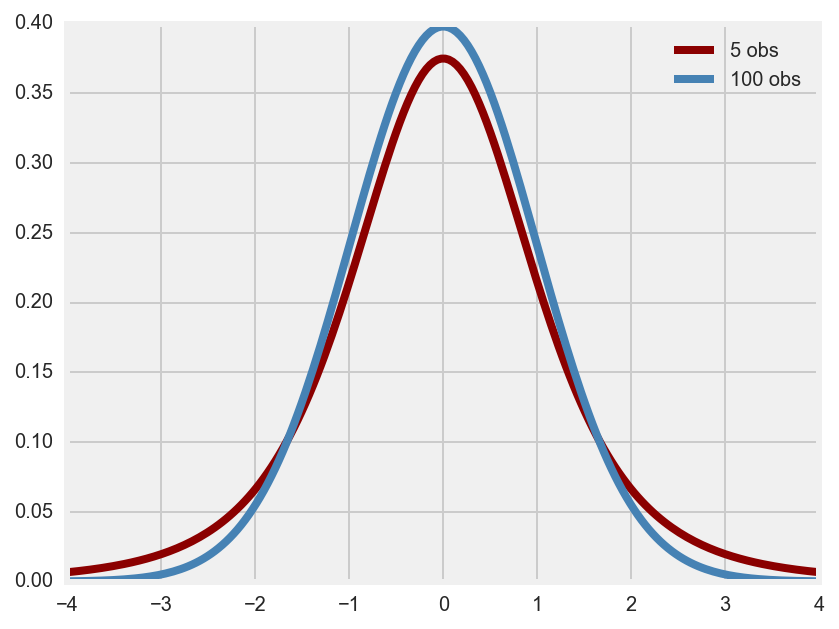

In [26]:
tdist5 = stats.t(4)
tdist100 = stats.t(99)

fig, ax = plt.subplots(figsize=(6,5))
x = np.linspace(-4, 4, 200)

y5 = tdist5.pdf(x)
y100 = tdist100.pdf(x)

ax.plot(x, y5, lw=4, color='darkred', label='5 obs')
ax.plot(x, y100, lw=4, color='steelblue', label='100 obs')

ax.legend(loc='upper right')
plt.show()

#### Calculate the confidence interval for the sample mean of age from the two t-distributions.

(This will be as if that measured sample mean was taken from 5 observations vs. 100 observations as opposed to the fact that it was actually taken from over 3000).

In [27]:
sample = np.random.choice(star.Age, replace=False, size=1000)
sample_mean = np.mean(sample)
sample_sem = np.std(sample)/np.sqrt(1000)
#print sample
print sample_mean, sample_sem

21.794 0.136870610432


In [28]:
t1000 = stats.t(999)

In [29]:
alpha = 0.01
conf_lower_z = sample_mean + sample_sem*normal.ppf(alpha/2.)
conf_upper_z = sample_mean + sample_sem*normal.ppf(1.-alpha/2.)

print conf_lower_z, sample_mean, conf_upper_z

21.4414446709 21.794 22.1465553291


In [30]:
conf_lower_t = sample_mean + sample_sem*t1000.ppf(alpha/2.)
conf_upper_t = sample_mean + sample_sem*t1000.ppf(1.-alpha/2.)

print conf_lower_t, sample_mean, conf_upper_t

21.4407698531 21.794 22.1472301469


---

## Hypothesis testing with HR data

Load in the HR data. Say we want to test whether the `satisfaction_level` is greater for management employees with high salary (job type is defined in the `sales` column) vs. management employees with low salary.

>$H_0$: There is no difference in satisfaction level between high and low salary management.

>$H_1$: There is a difference in satisfaction level between high and low salary management.

**Plot the distribution of satisfaction level for the two groups.**

In [31]:
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [32]:
hr.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

---

### Set up the hypothesis test

We are going examine whether there is a significant difference between the mean satisfaction rate between the groups.

**Calculate the difference in mean satisfaction rate between groups.**

In [33]:
hr.sales.value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: sales, dtype: int64

In [34]:
high_sal_mask = (hr.sales == 'management') & (hr.salary == 'high')
low_sal_mask = (hr.sales == 'management') & (hr.salary == 'low')
high_sat = hr[high_sal_mask].satisfaction_level.values
low_sat = hr[low_sal_mask].satisfaction_level.values

In [35]:
print high_sat.shape, low_sat.shape

(225,) (180,)


In [36]:
diff = np.mean(high_sat) - np.mean(low_sat)
diff

0.042611111111111044

Because we have two different groups, we need to pool the variance in order to find the error around our measurement of the mean. We can be conservative and not assume that the two groups have equal variance. 

The formula for the pooled standard error of the mean (not assuming equal variances) is:

### $$ s_p = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}} $$

**Calculate the pooled standard error of the mean.**

In [37]:
pool_sem = np.sqrt((np.var(high_sat)/len(high_sat)) + (np.var(low_sat)/len(low_sat)))
pool_sem

0.022922697597746875

Next, let's find the t-statistic for our difference between means. Remember that our null hypothesis $H_0$ states that there is no difference between means. Therefore we want to find where our difference in mean satisfaction would fall on that t-distribution.

The t-distribution of sample means will have a mean 0 and standard deviation 1. We therefore need to have our sample mean in terms of standard deviations:

### $$ t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}} $$

**Standardize our difference between mean satsifaction by dividing by the standard error of the mean.**

In [38]:
tstat = diff/pool_sem
tstat

1.8589047353353119

**Set up the null hypothesis t-distribution.**

We can choose a conservative degrees of freedom that is the smaller between $n_1 - 1$ and $n_2 -1$. 

In [39]:
tdist = stats.t(180-2)


**Find the 95% confidence interval for our sample difference between means.**

What does this confidence interval tell us? 

In [40]:
alpha = 0.07
upper = tdist.ppf(1 - alpha/2.)
lower = tdist.ppf(alpha/2.)

upper_bound = diff + upper*pool_sem
lower_bound = diff + lower*pool_sem
print lower_bound, diff, upper_bound

0.000825883652472 0.0426111111111 0.0843963385697


---

### Type I error ($\alpha$),  Type II error ($\beta$), and Power ($1 - \beta$)

We tend to think a lot about Type I error, or the probability of false positives. It's counterpart, Type II error, is also quite important. Type II error measures the risk of false negatives. 

Whereas the p-value or $\alpha$ is the probability that we could have gotten our measured effect by chance due to sampling error, the $\beta$ is the probability that we _accepted_ the null hypothesis by chance when in fact the alternative hypothesis is true.

The more common formulation of this false negative rate is **Power**, which is $1 - \beta$. You can think of power as the probability of correctly accepting the alternative hypothesis when it is true.

---

Below is an interactive visualization that helps show the relationship between the $\alpha$ threshold and the power of the experiment. Decreasing alpha (making the threshold more strict) necessarily reduces our power. Alternatively, the more lenient we are about Type I error rate the more we reduce Type II error rate.

In [41]:
from ipywidgets import *
from IPython.display import display

In [42]:
def power_plotter(std, alpha, effect):
    unit_norm = stats.norm(0,1)
    z_alpha = unit_norm.ppf(1-alpha/2.)
    z_power = (effect/std) - z_alpha 
    
    null_dist = stats.norm(0, std)
    alt_dist = stats.norm(effect, std)
    
    power = unit_norm.cdf(z_power)
    
    z_type1 = null_dist.ppf(1-alpha/2)
    
    xvals = np.linspace(-5*std, effect+(5*std), 300)

    fig, axarr = plt.subplots(2, 1, figsize=(14,6))

    axarr[0].plot(xvals, null_dist.pdf(xvals), color='grey', lw=4, label='Null')
    axarr[1].plot(xvals, alt_dist.pdf(xvals), color='black', lw=4, label='Alternative')

    type1_x = np.linspace(z_type1, effect+(5*std))

    axarr[0].axvline(z_type1, lw=3, ls='dashed', color='darkred')
    axarr[0].fill_between(type1_x, 0, null_dist.pdf(type1_x), color='darkred', 
                          alpha=0.5, hatch = '///', label='alpha = {:.2f}'.format(alpha))
    
    axarr[1].axvline(z_type1, lw=3, ls='dashed', color='steelblue')
    axarr[1].fill_between(type1_x, 0, alt_dist.pdf(type1_x), color='steelblue', 
                          alpha=0.5, hatch = '///', label='power = {:.2f}'.format(power))


    axarr[0].set_ylim([0, 0.50])
    axarr[1].set_ylim([0, 0.50])
    
    axarr[0].set_xlim([-5,10])
    axarr[1].set_xlim([-5,10])
    
    axarr[0].legend(loc='upper left', fontsize=14)
    axarr[1].legend(loc='upper left', fontsize=14)

    plt.show()
    

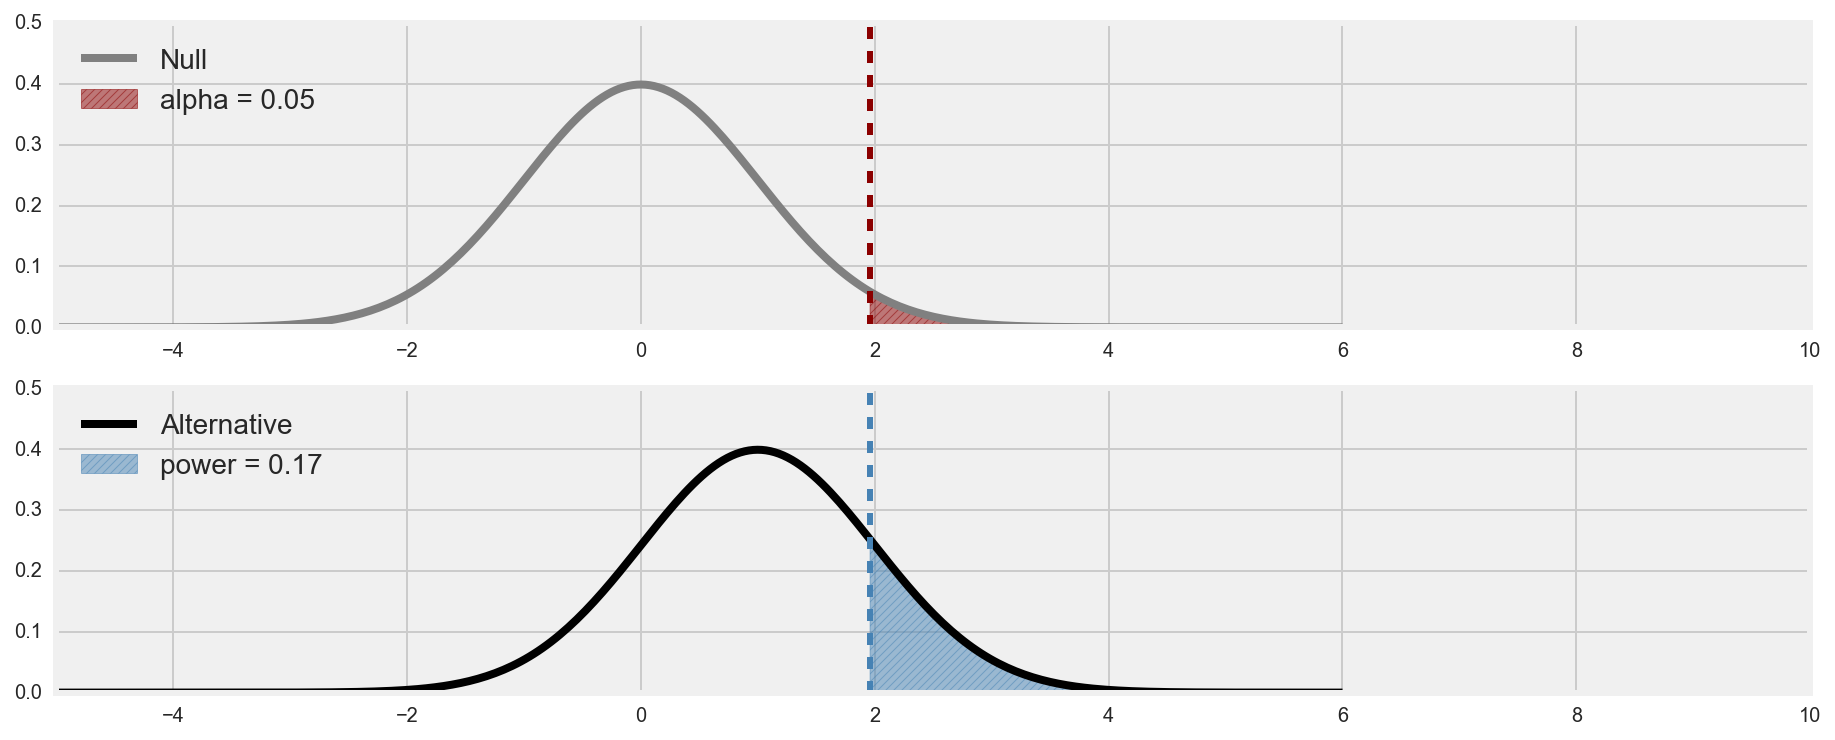

<function __main__.power_calcplotter>

In [43]:
def power_calcplotter(std_effect=1.0, alpha=0.05, effect=1.0):
    power_plotter(std_effect, alpha, effect)
    

interact(power_calcplotter, 
         std_effect=FloatSlider(min=0.5, max=3.0, value=1.0, step=0.1),
         alpha=FloatSlider(min=0.01, max=0.50, value=0.05, step=0.01),
         effect=FloatSlider(min=0.1, max=5.0, value=1.0, step=0.1))

---

### Power analysis and sample size calculation

It is often the case that we are not just analyzing data already gathered, but instead want to set up an experiment to test a hypothesis we have. The design of experiments is a deep and extensive topic - for now we will just be covering power analysis and sample size calculation.

If we are setting up an experiment with a control condition and experimental condition to test a hypothesis, we will want to know how many subjects we should recruit for each group. In order to calculate the sample size we will need to know:

1. Our desired Type I error rate ($\alpha$)
2. Our desired Type II error rate ($\beta$ or more commonly power, $1 - \beta$)
3. The expected size of the effect, or mean difference between groups.
4. The expected standard deviation of measurement.

Often the expected effect size and the standard deviation of measurement will need to be estimated from prior work or other information.

**Sample size calculations are hypothetical.** Because we can't really know until we actually collect the data, these are just guidelines for the setup of the experiment and should therefore be fairly conservative. There is good reason to not exceed the required number of subjects by too much though: there are marginal returns with more subjects, and tests are often costly to run.

---

With $\theta$ being a test statistic that is a difference between groups,

$SE_{\theta}$ the standard error of measurement on the test statistic,

$\alpha$ the specified Type I error threshold value (p-value),

$Z_{\alpha}$ the z-statistic for the specified $\alpha$ (position on the unit-variance normal distribution),

The z-statistic for the _power_, which is $1 - \beta$ or in other words 1 minus the Type II error rate, is calculated:

### $$ Z_{power} = \frac{\theta}{SE_{\theta}} - Z_{\alpha/2} $$

This can be re-written with $\sigma^2$, the (assumed) equal standard deviation of measurements in the two groups, 

$n_1$, the number of people in group 1,

and $r$, the ratio of group 2 to group 1

### $$ Z_{power} = \frac{\theta}{ \sqrt{ \frac{\sigma^2}{n_1} + \frac{\sigma^2}{rn_1} } } - Z_{\alpha/2} $$

If you solve for $n_1$ you get:

### $$ n_1 = \frac{r+1}{r} \frac{\sigma^2 (Z_{power} + Z_{\alpha/2})^2}{\theta^2} $$

If you assume that the two groups will have equal sizes (which is most often the case when preparing a test: the best power for lowest number of subjects is achieved with equal groups), $r = 1$ and the formula reduces to:

### $$ n = \frac{2 \sigma^2 (Z_{power} + Z_{\alpha/2})^2}{\theta^2} $$

where $n$ is the number of subjects requred in each group.



In [44]:
def n_calculator(std, desired_power, alpha, effect):
    unit_norm = stats.norm(0,1)
    z_power = unit_norm.ppf(desired_power)
    z_alpha = unit_norm.ppf(1-alpha/2.)
    n = np.ceil((2. * std * (z_power + z_alpha)**2) / (effect**2))
    return n


In [45]:
def required_sample_plotter(std=1, desired_power=0.8, alpha=0.05, effect=0.5):
    n = n_calculator(std, desired_power, alpha, effect)
    
    fig, ax = plt.subplots(figsize=(12,5))
    
    null_dist = stats.norm(0, std)
    alt_dist = stats.norm(effect, std)
        
    null_means = np.array([np.mean(null_dist.rvs(n)) - np.mean(null_dist.rvs(n)) for i in range(1000)])
    alt_means = np.array([np.mean(alt_dist.rvs(n)) - np.mean(null_dist.rvs(n)) for i in range(1000)])
    
    alpha_null_val = stats.scoreatpercentile(null_means, (1. - (alpha/2))*100)
    
    pct_alt_above = np.sum(alt_means > alpha_null_val)/1000.
    pct_null_above = np.sum(null_means > alpha_null_val)/1000.
        
    ax = sns.distplot(null_means[null_means < alpha_null_val],
                      ax=ax, color='grey', kde=False, hist_kws=dict(alpha=0.2))
    ax = sns.distplot(null_means[null_means >= alpha_null_val],
                      ax=ax, color='darkred', kde=False, hist_kws=dict(alpha=0.4),
                      label='alpha')
    
    ax = sns.distplot(alt_means[alt_means < alpha_null_val], ax=ax,
                      color='steelblue', kde=False, hist_kws=dict(alpha=0.4),
                      label='beta / (1 - power)')
    ax = sns.distplot(alt_means[alt_means >= alpha_null_val], 
                      ax=ax, color='grey', kde=False, hist_kws=dict(alpha=0.2))
    
    ax.axvline(alpha_null_val, lw=3, ls='dashed', color='black')
    
    n_str = 'N = '+str(int(n))
    effect_str = 'effect size = {:.2f}'.format(float(effect)/std)
    power_str = 'power = {:.3f}'.format(pct_alt_above)
    alpha_str = 'alpha = {:.3f}'.format(pct_null_above)
    
    ax.annotate('\n'.join([n_str, effect_str, alpha_str, power_str]),
                xy=(0.95, 0.6),
                xycoords='axes fraction', horizontalalignment='right', 
                fontsize=14, weight='bold', color='black')
    
    ax.legend(loc='upper left')
    

//anaconda/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:127: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return self._random_state.standard_normal(self._size)


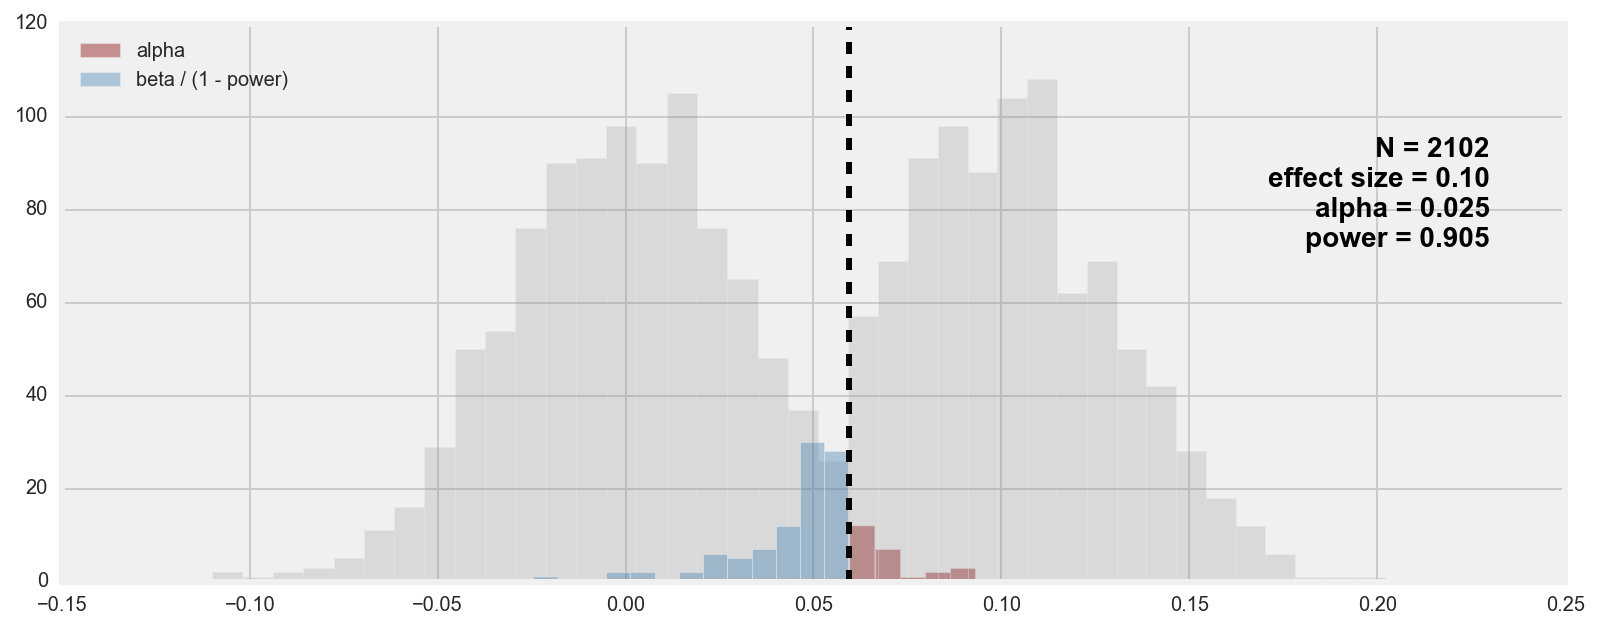

In [46]:
deltas = required_sample_plotter(1, 0.9, 0.05, 0.1)

---

## Bootstrapping

Bootstrapping is a powerful resampling method that allows us to estimate practically any statistic and our uncertainty around it directly from the data without needing to make assumptions about the distribution of the statistics.

The idea behind bootstrapping is that inferences we can draw from samples of our sample can be applied to our inference about the overall population that the original sample is drawn from. Essentially, bootstrap samples are to our original sample as our original sample is to the overall population.

> Infer $\theta$ of population from sample $\hat{\theta}_{s}$ with uncertainty estimated from sample

> Infer uncertainty around $\hat{\theta}_{s}$ (distribution of parameter) estimated from multiple bootstrap samples

Because our sample is assumed to be representative of the overall population (drawn randomly from the population), we can then by extension say that inferences we make comparing our sample to random subsamples are applicable to the overall population. We create these bootstrap samples in the same way that we assume we are drawing our sample from the population.

Why and when is bootstrapping useful? In the case we have been looking at so far, the estimation of sample means or the difference between means, it is not as immediately useful because the mean has nice properties. But for some types of statistics like the sample median or the sample correlation, it is hard to measure our uncertainty about the statistics because the standard deviations of the statistics aren't simple to compute.

---

### Confidence intervals for the median age in Starcraft data

Assuming:

1. $N$ is large
2. The sample of measurements is drawn from a normally distributed population

We could calculate the sample error of the median as:

### $$ \text{s.e. median} = 1.2533 \cdot \text{s.e. mean} $$

But how do we know that the population we are drawing our sample from is normally distributed? Furthermore, why would we want the median as opposed to the mean if we know that the population is normally distributed?

Typically we will want the median and a confidence interval around it when we suspect a non-normally distributed population. Let's take the distribution of APM (actions per minute) from our Starcraft data as the overall population.

**Plot the distribution of APM from the Starcraft data with a vertical line indicating the median.**

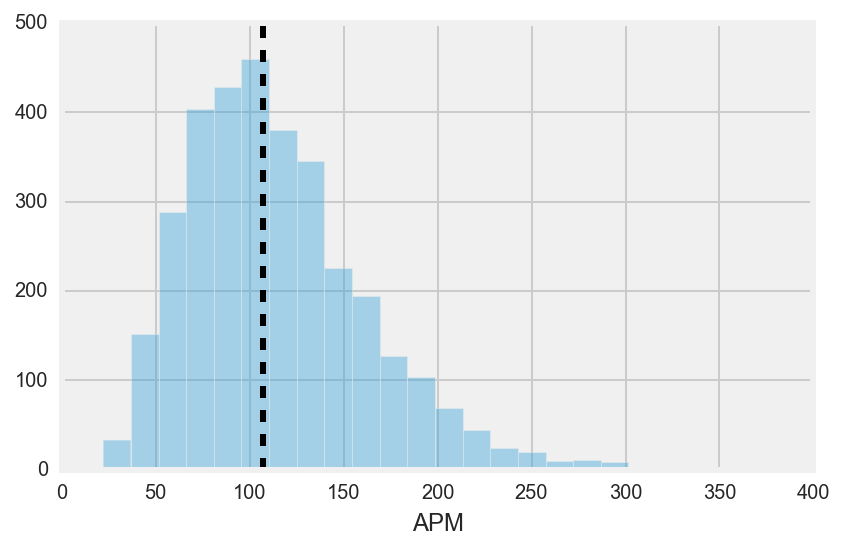

In [47]:
ax = sns.distplot(star.APM, bins=25, kde=False)
ax.axvline(np.median(star.APM), lw=3, ls='dashed', color='black')

**Take a random sample of 50 people and their APM values from the overall Starcraft population.**

In [48]:
sample = np.random.choice(star.APM, size=50, replace=False)

In [49]:
print np.median(sample), np.median(star.APM)

100.3041 107.0703


#### Calculate a 99% confidence interval for the median for your sample computed with the formula above.

In [50]:
tdist = stats.t(49)
sample_sem = np.std(sample)/np.sqrt(50)
sample_median_err = sample_sem*1.2533

In [51]:
print sample_sem, sample_median_err

6.60313374525 8.27570752292


In [68]:
alpha = 0.01
sample_median = np.median(sample)
upper = sample_median_err * tdist.ppf(1-alpha/2.) + sample_median
lower = sample_median_err * tdist.ppf(alpha/2.) + sample_median
print lower, sample_median, upper

78.1256012907 100.3041 122.482598709


**Plot the sample median and the confidence interval bounds with the histogram of sample APM.**

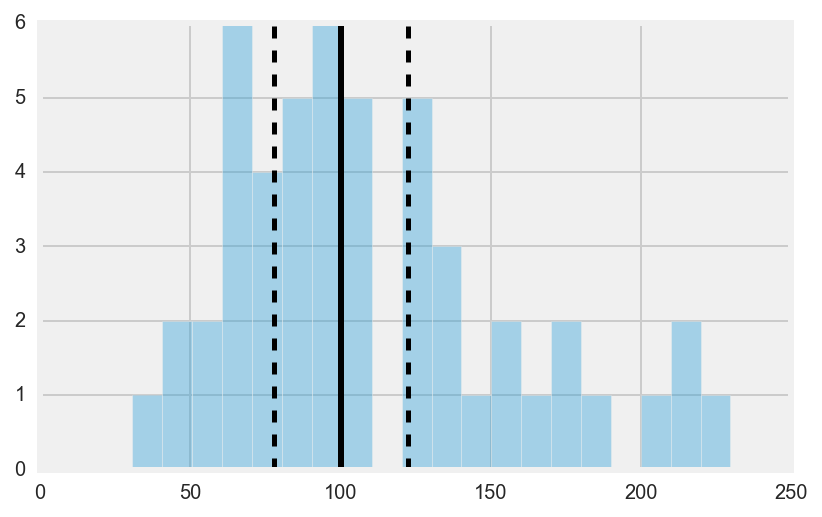

In [53]:
ax = sns.distplot(sample, bins=20, kde=False)
ax.axvline(sample_median, lw=3, color='black')
ax.axvline(lower, lw=2.5, color='black', ls='dashed')
ax.axvline(upper, lw=2.5, color='black', ls='dashed')

Instead of using that inappropriate formula, we can use bootstrapping to calculate the confidence interval for our sample median.

There are a variety of formulas to measure uncertainty bounds with bootstrapping. We'll use the most straightforward way by computing the median across many random bootstrap samples and then taking the lower and upper percentiles of medians according to our 99% threshold.

The pseudocode for this bootstrapping procedure is below. This is an example of **nonparametric bootstrapping**.

```
for specified number of bootstrap iterations
    create a bootstrap sample by randomly selecting observations with replacement from your sample 
        (same size as sample)
    calculate the statistic of interest on bootstrap sample

calculate lower and upper percentile bounds of bootstrap statistics according to threshold
```

**Write a function to calculate a statistic of interest on a specified number of bootstrap iterations from a sample.**

In [64]:
bootstrapped_medians = []

for i in range(1000):
    subsample = np.random.choice(sample, size=len(sample), replace=True)
    bootstrapped_medians.append(np.median(subsample))

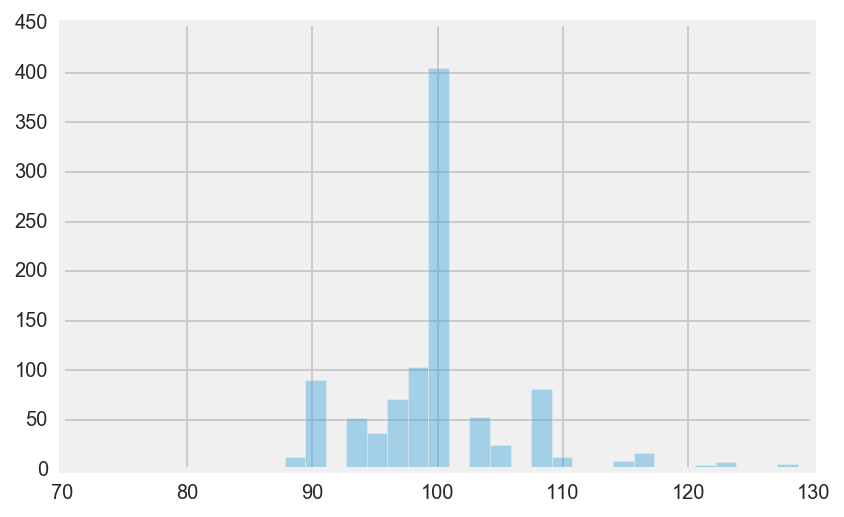

In [65]:
sns.distplot(bootstrapped_medians, kde=False, bins=30)

#### Calculate the confidence bounds for 99% confidence interval using the bootstrapping function with 1000 iterations.

The `scipy.stats.scoreatpercentile()` function will help you get these values.

In [75]:
lower_boot = stats.scoreatpercentile(bootstrapped_medians, 0.01)
upper_boot = stats.scoreatpercentile(bootstrapped_medians, 99.99)

print lower_boot, sample_median, upper_boot

80.23363632 100.3041 128.7687


#### Plot the bootstrap confidence interval bounds vs. the original

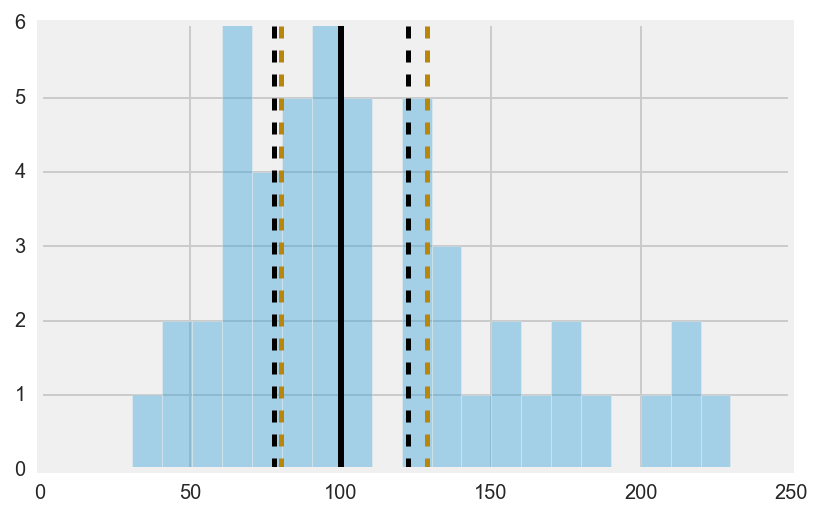

In [76]:
ax = sns.distplot(sample, bins=20, kde=False)
ax.axvline(sample_median, lw=3, color='black')
ax.axvline(lower, lw=2.5, color='black', ls='dashed')
ax.axvline(upper, lw=2.5, color='black', ls='dashed')
ax.axvline(lower_boot, lw=2.5, color='darkgoldenrod', ls='dashed')
ax.axvline(upper_boot, lw=2.5, color='darkgoldenrod', ls='dashed')

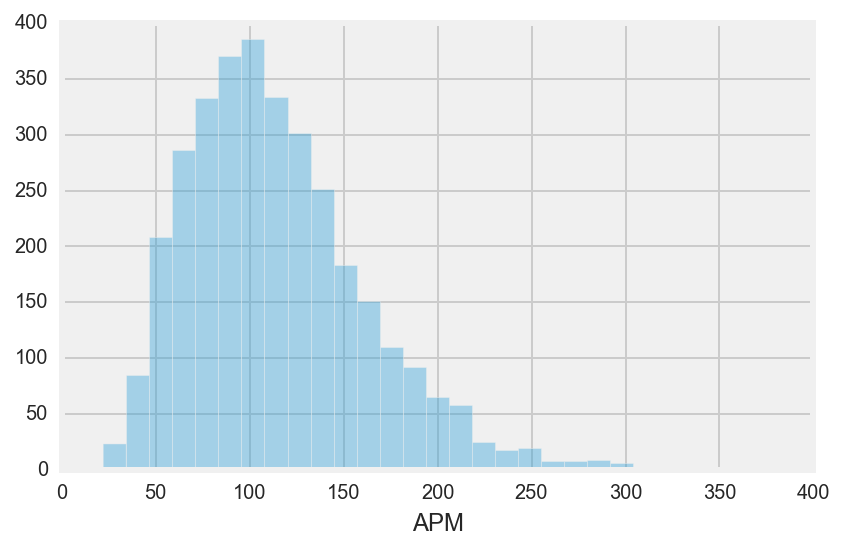

In [72]:
sns.distplot(star.APM, bins=30, kde=False)

---

### Bootstrapping regression coefficients

Bootstrapping is not just limited to univariate statistics. The nonparametric bootstrap can be used to find the distributions of parameters in regressions as well. 

Below you'll get the coefficients out of multiple regressions built on bootstrap samples and then plot the confidence bounds on your regression.

**Sample 100 people at random from the HR dataset.**

In [77]:
sample = hr.sample(n=100)

In [78]:
sample.columns

Index([u'satisfaction_level', u'last_evaluation', u'number_project',
       u'average_montly_hours', u'time_spend_company', u'Work_accident',
       u'left', u'promotion_last_5years', u'sales', u'salary'],
      dtype='object')

**Build a regression predicting satisfaction level from number of projects using the sample.**

Print out the intercept and coefficient.

In [85]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

X = sample[['number_project']].values
y = sample['satisfaction_level'].values

lr.fit(X, y)
orig_int = lr.intercept_
orig_coef = lr.coef_[0]
print lr.intercept_, lr.coef_

0.777020895522 [-0.04336318]


#### Plot the regression line 

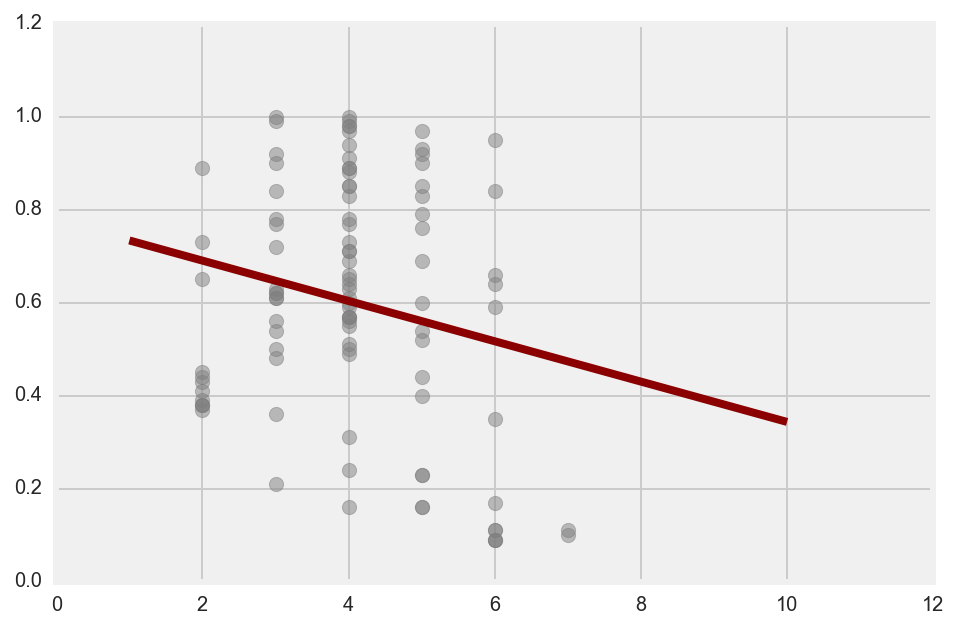

In [80]:
fig, ax = plt.subplots(figsize=(7,5))

ax.scatter(X[:,0], y, s=50, alpha=0.5, color='gray')

xvals = np.linspace(1,10)
ax.plot(xvals, lr.predict(xvals[:, np.newaxis]), color='darkred',
        lw=4)

plt.show()

#### Bootstrap the regression 1000 times.

We can get confidence bounds for our regression line parameters (intercept and slope) by using bootstrapping.

For the number of bootstrap iterations:

1. Resample with replacement the dataset (as you did before), keeping the size of the dataset the same.
2. Run the regression on the resampled dataset.
3. Keep track of the regression parameters for each bootstrap iteration.

In [82]:
boot_ints = []
boot_coefs = []

lr = LinearRegression()

for i in range(1000):
    subsample = sample.sample(n=100, replace=True)
    
    X = subsample[['number_project']].values
    y = subsample['satisfaction_level'].values

    lr.fit(X, y)
    boot_ints.append(lr.intercept_)
    boot_coefs.append(lr.coef_[0])

#### Calculate the 95% confidence intervals on your intercept and slope from the bootstrap samples.

In [84]:
lower_coef = stats.scoreatpercentile(boot_coefs, 2.5)
upper_coef = stats.scoreatpercentile(boot_coefs, 97.5)
print lower_coef, upper_coef

-0.0854339750891 0.00870832184467


#### Plot the regression lines for your 95% confidence bound coefficients on number of projects.

You can keep the intercept of your regression on the original sample. This isn't entirely appropriate since each regression had its own intercept and slope, but you are specifically interested in the distribution of the coefficient on your predictor.

In [86]:
def predict(beta0, beta1, xvals):
    return beta0 + beta1*np.array(xvals)

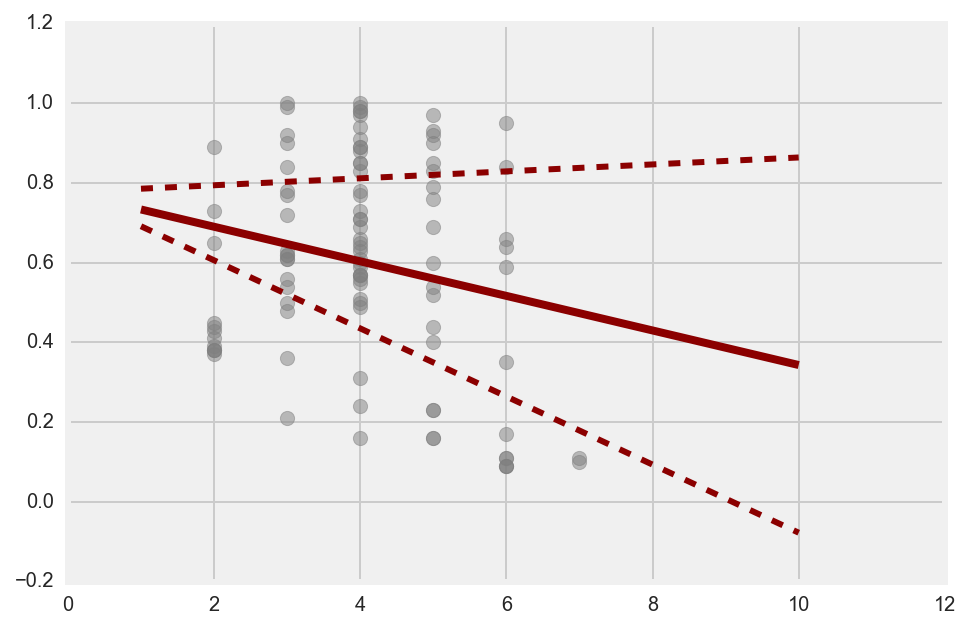

In [87]:
fig, ax = plt.subplots(figsize=(7,5))

ax.scatter(X[:,0], y, s=50, alpha=0.5, color='gray')

xvals = np.linspace(1,10)
ax.plot(xvals, predict(orig_int, orig_coef, xvals), color='darkred',
        lw=4)
ax.plot(xvals, predict(orig_int, lower_coef, xvals), color='darkred',
        lw=3, ls='dashed')
ax.plot(xvals, predict(orig_int, upper_coef, xvals), color='darkred',
        lw=3, ls='dashed')

plt.show()